In [1]:
import pandas as pd
import numpy as np

import json

from scripts.utils import SimulateData
from stopsignalmetrics.ssrtmodel import SSRTmodel

from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn as sns

## Suffix
### Indicates which set of results to view

In [2]:
suffix = 'SSRTscale-85'

# SSRT by SSD

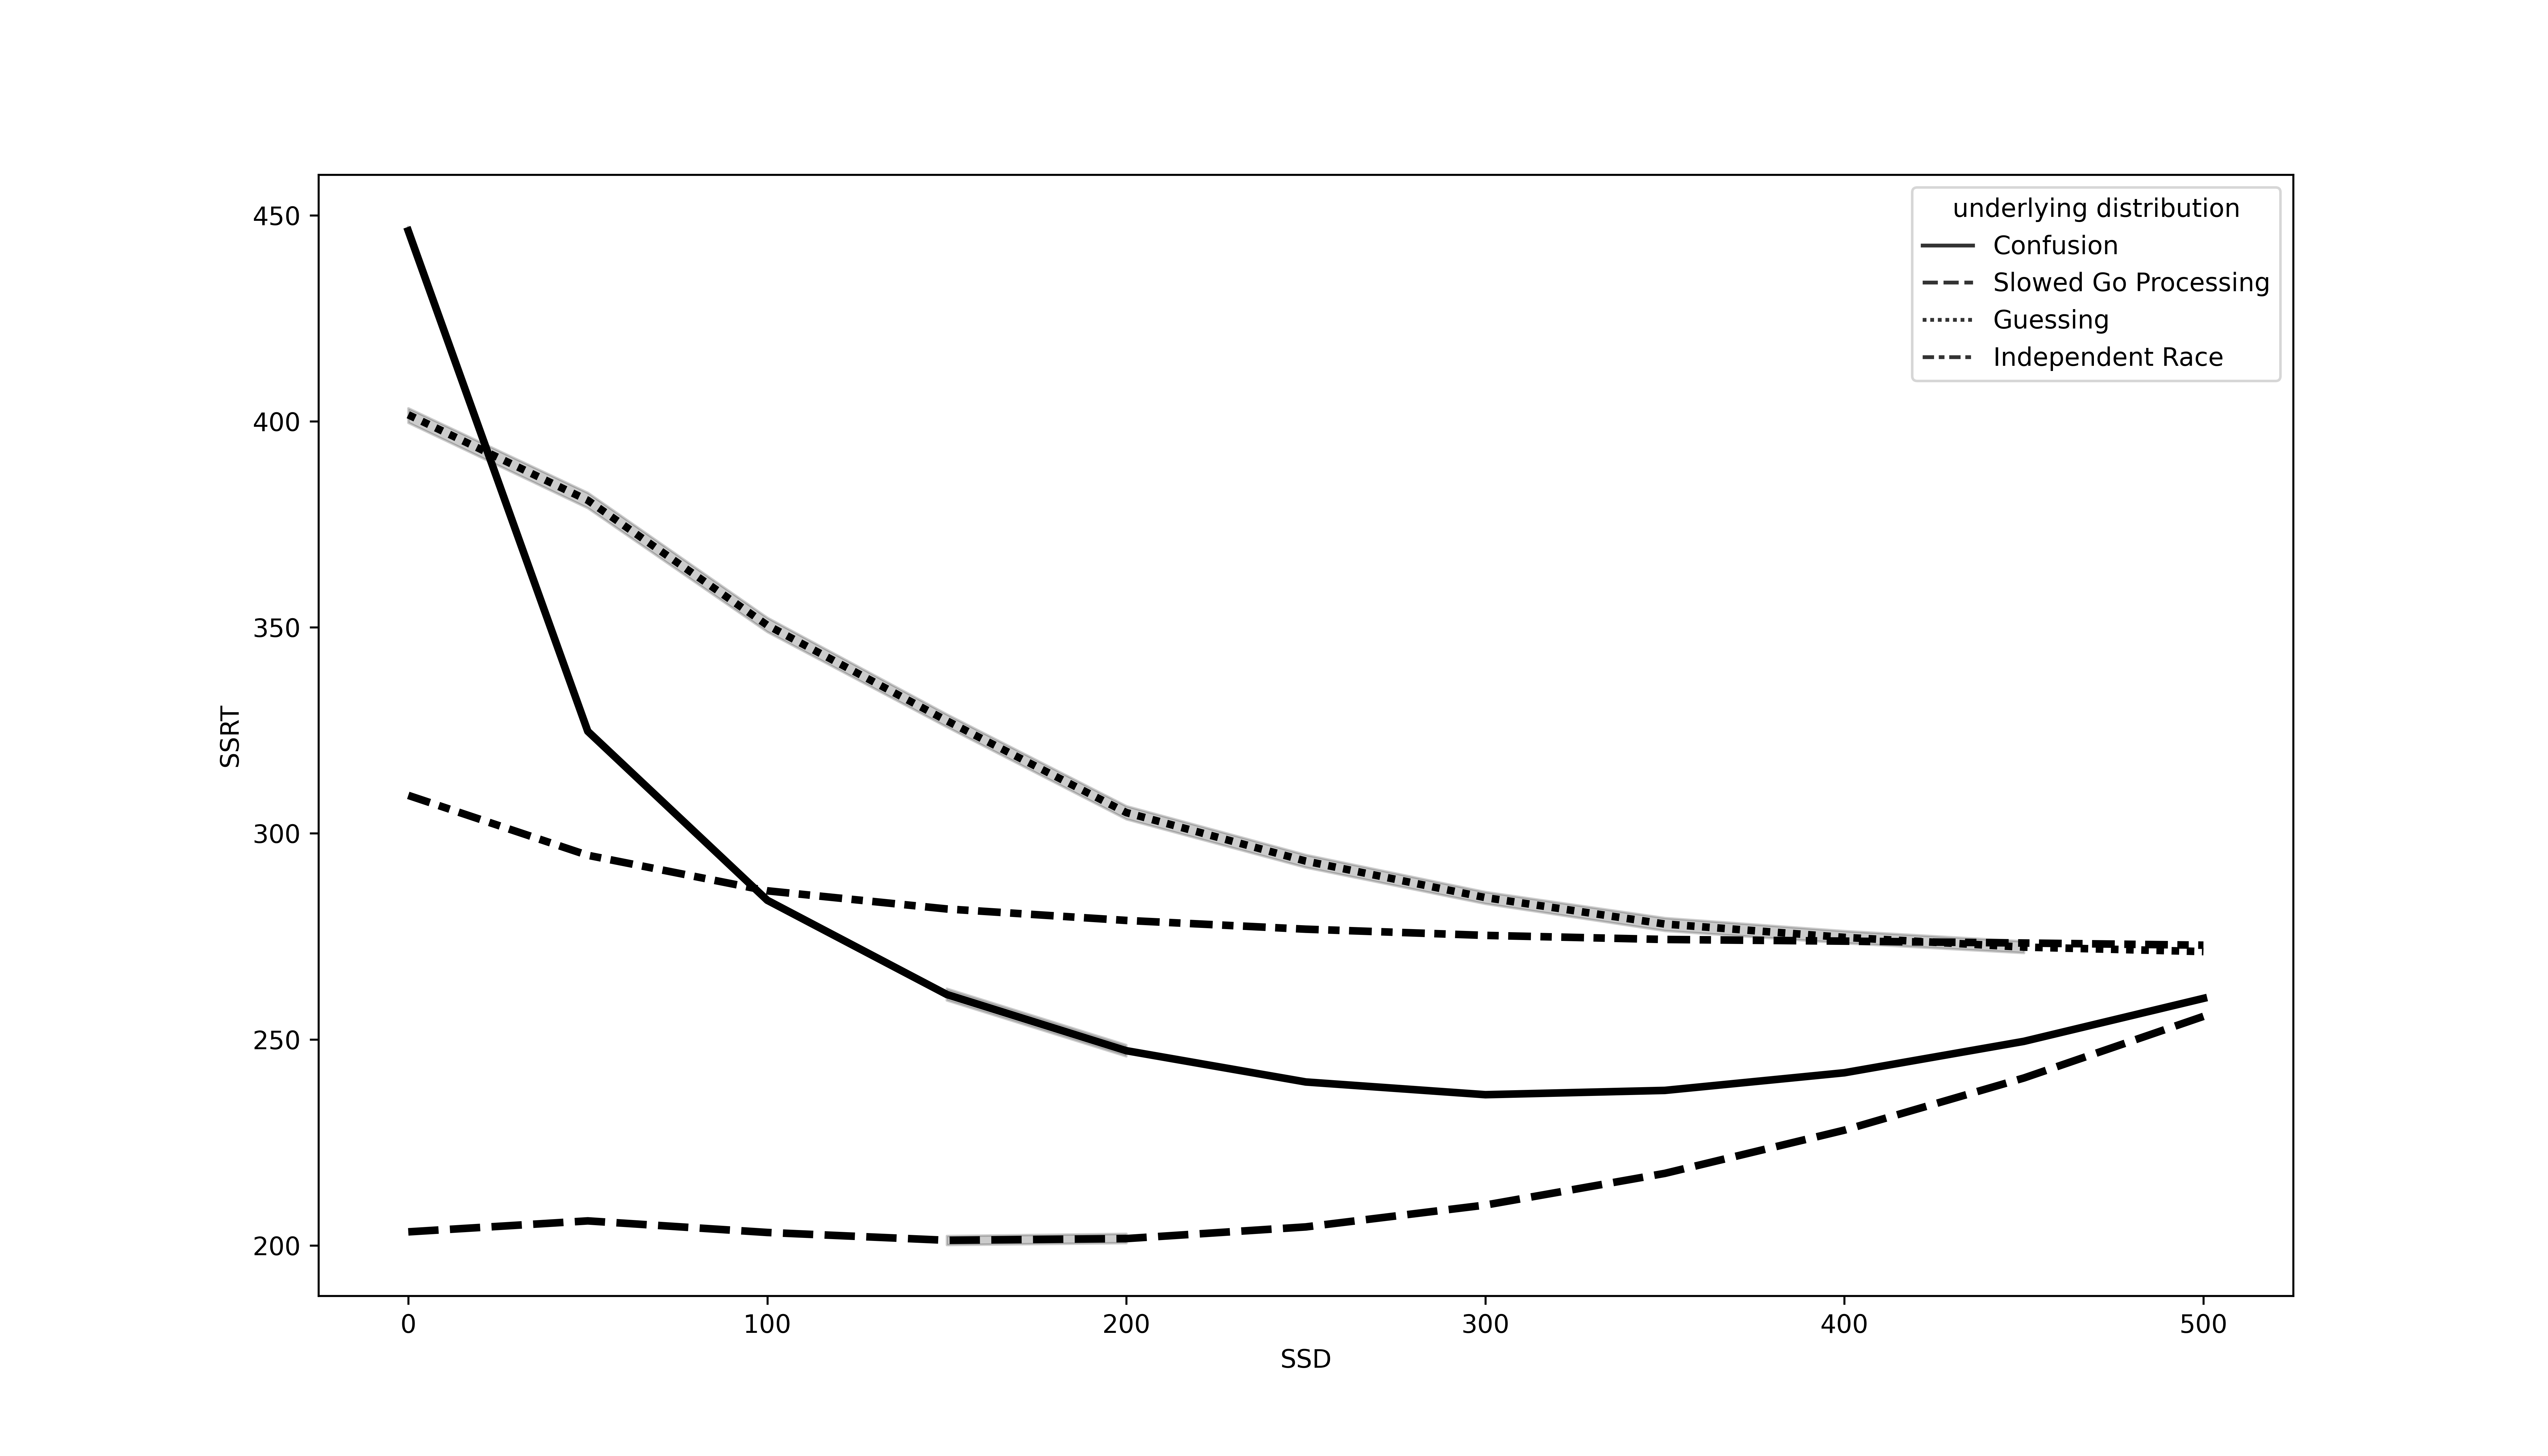

In [3]:
Image('figures/%s/SSRT_by_SSD.png' % suffix)

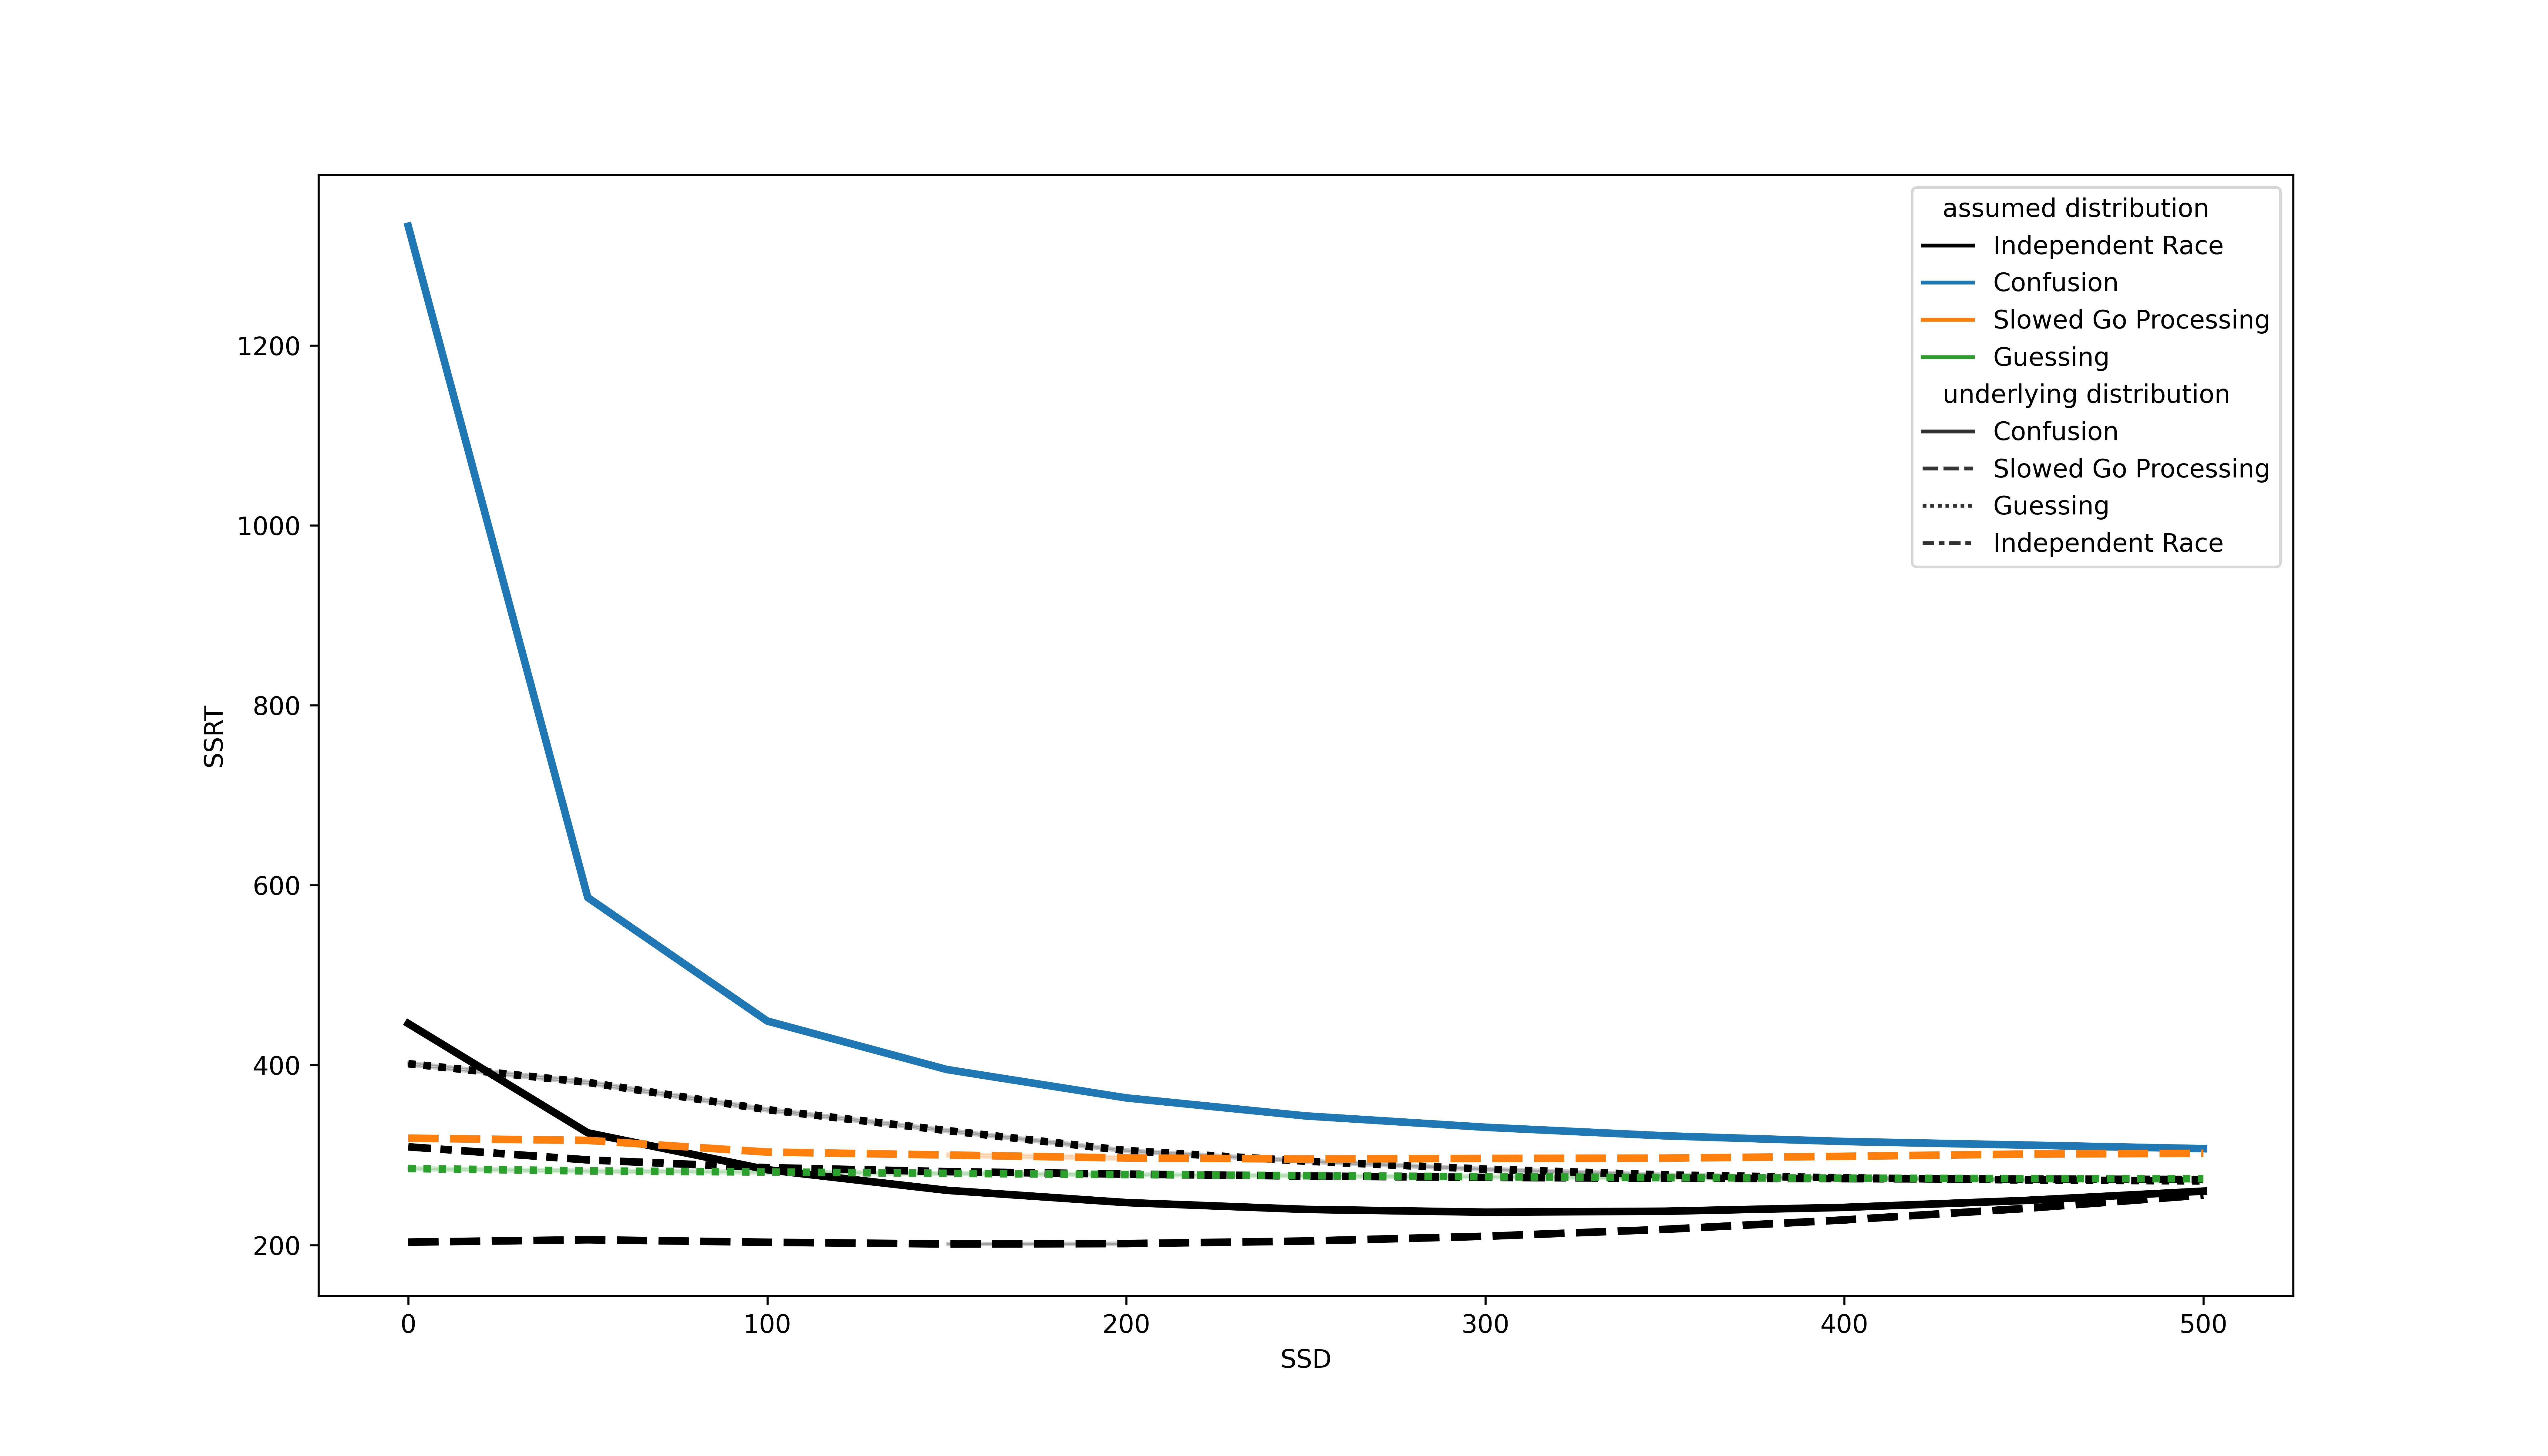

In [4]:
Image('figures/%s/SSRT_by_SSD_supplement.png' % suffix)

# Inhibition Function

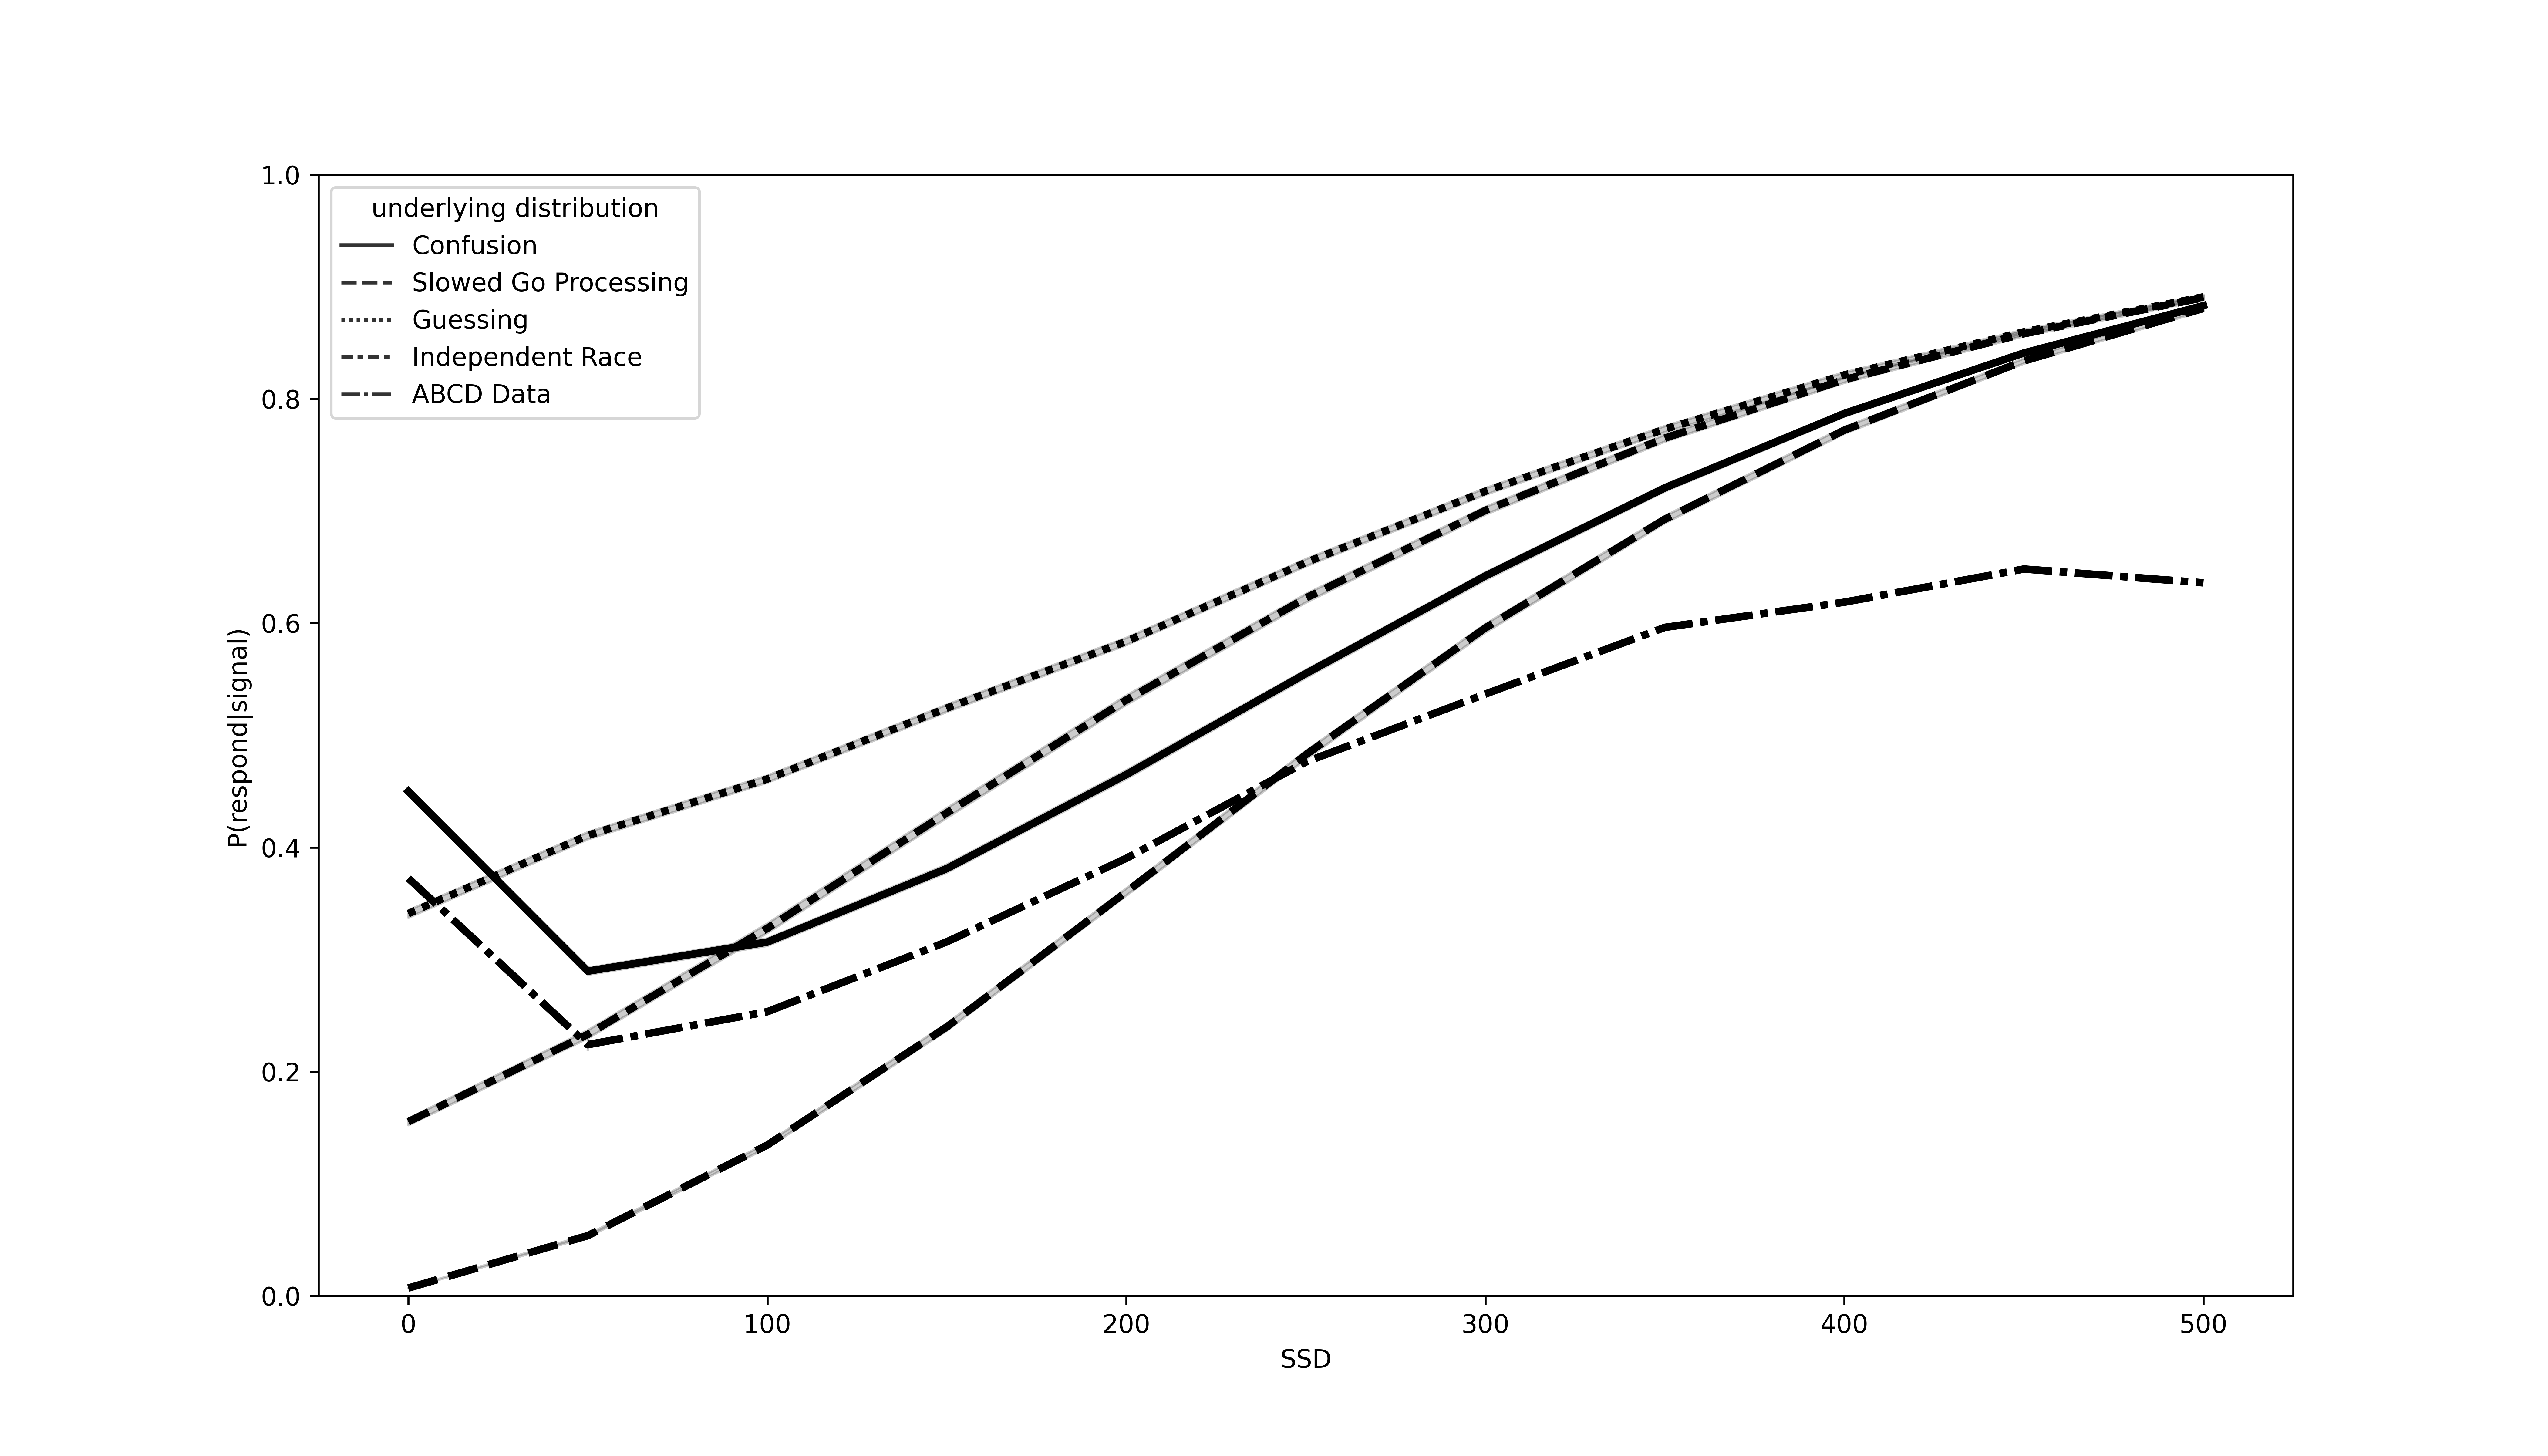

In [5]:
Image('figures/%s/inhibition_function.png' % suffix)

# Individual Differences

In [6]:
def add_identity(axes, *line_args, **line_kwargs):
    identity, = axes.plot([], [], *line_args, **line_kwargs)
    def callback(axes):
        low_x, high_x = axes.get_xlim()
        low_y, high_y = axes.get_ylim()
        low = max(low_x, low_y)
        high = min(high_x, high_y)
        identity.set_data([low, high], [low, high])
    callback(axes)
    axes.callbacks.connect('xlim_changed', callback)
    axes.callbacks.connect('ylim_changed', callback)
    return axes

In [7]:
ssrt_df = pd.read_csv('ssrt_metrics/expected_ssrts_%s.csv' % suffix, index_col=0)

# reformatting - was multiindex
ssrt_df.columns = [ f'gen-{gen}_SSRT-{ssrt}' for gen, ssrt in zip(ssrt_df.loc['underlying distribution', :].values, ssrt_df.columns)]
ssrt_df = ssrt_df.drop(['underlying distribution', 'NARGUID'])

for col in ssrt_df.columns:
    ssrt_df[col] = ssrt_df[col].astype(float)

    
# confirm that no kludge is required - check SSRTscale-0_RTscale-0 for use of kludge
tracking_ssrts = ['gen-graded_both_SSRT-tracking', 'gen-graded_go_SSRT-tracking.1','gen-guesses_SSRT-tracking.2', 'gen-standard_SSRT-tracking.3']
for col in tracking_ssrts:
    assert sum(ssrt_df[col].isnull())==0

In [8]:
# sim_rt_info = pd.read_csv('simulated_data/sim_rt_meanStd.csv', index_col = 0)

In [9]:
# getting expect SSRTs
mus_path = 'abcd_data/assigned_mus_%s.json' % suffix
with open(mus_path, 'r') as f:
    mus_dict = json.load(f)
    
mus_df = pd.DataFrame(mus_dict).T

In [10]:
mus_df.head()

goRT        go        SSRT      stop
003RTV85  575.295505  0.190369  158.731993  0.919693
007W6H7B  453.614919  0.247761  222.859696  0.578504
00CY2MDM  617.052023  0.176351  269.084639  0.456445
00HEV6HB  546.564175  0.201384  158.648178  0.920402
00J52GPG  577.825255  0.189457  269.611172  0.455350

In [11]:
monster_df = pd.concat([mus_df.add_prefix('assigned_'), ssrt_df], 1, sort=True)
monster_df.columns = [col.split('.')[0] for col in monster_df.columns]
monster_df = monster_df.loc[monster_df['gen-standard_SSRT-fixed'].notnull()]

In [12]:
monster_df.shape

(8207, 28)

In [13]:
def make_plot_square(ax):
    lowx, highx = ax.get_xlim()
    lowy, highy = ax.get_ylim()
    low = min(lowx, lowy)
    high = max(highx, highy)
    ax.set_xlim((low, high))
    ax.set_ylim((low, high))
    return ax

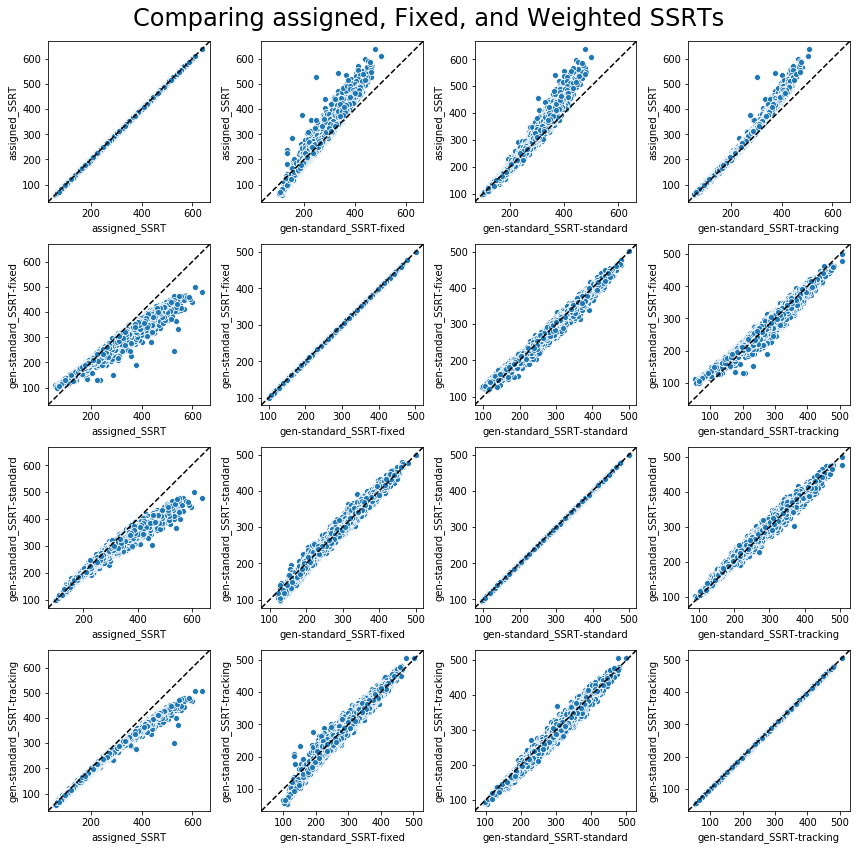

In [14]:
fig, axes = plt.subplots(4, 4, figsize=(12,12))

columns = ['assigned_SSRT', 'gen-standard_SSRT-fixed', 'gen-standard_SSRT-standard', 'gen-standard_SSRT-tracking']
for idx,coli in enumerate(columns):
    for jdx, colj in enumerate(columns):
        ax = sns.scatterplot(x=colj, y=coli, data=monster_df, ax=axes[idx, jdx])
        ax = make_plot_square(ax)
        _ = add_identity(ax, color='k', ls='--')
_ = fig.suptitle('Comparing assigned, Fixed, and Weighted SSRTs', fontsize=24)
fig.tight_layout()
fig.subplots_adjust(top=0.94)

In [15]:
monster_df[columns].corr(method='spearman')

assigned_SSRT  gen-standard_SSRT-fixed  \
assigned_SSRT                    1.000000                 0.978784   
gen-standard_SSRT-fixed          0.978784                 1.000000   
gen-standard_SSRT-standard       0.987164                 0.989271   
gen-standard_SSRT-tracking       0.997752                 0.983288   

                            gen-standard_SSRT-standard  \
assigned_SSRT                                 0.987164   
gen-standard_SSRT-fixed                       0.989271   
gen-standard_SSRT-standard                    1.000000   
gen-standard_SSRT-tracking                    0.988095   

                            gen-standard_SSRT-tracking  
assigned_SSRT                                 0.997752  
gen-standard_SSRT-fixed                       0.983288  
gen-standard_SSRT-standard                    0.988095  
gen-standard_SSRT-tracking                    1.000000

# Comparing Fixed SSRTs

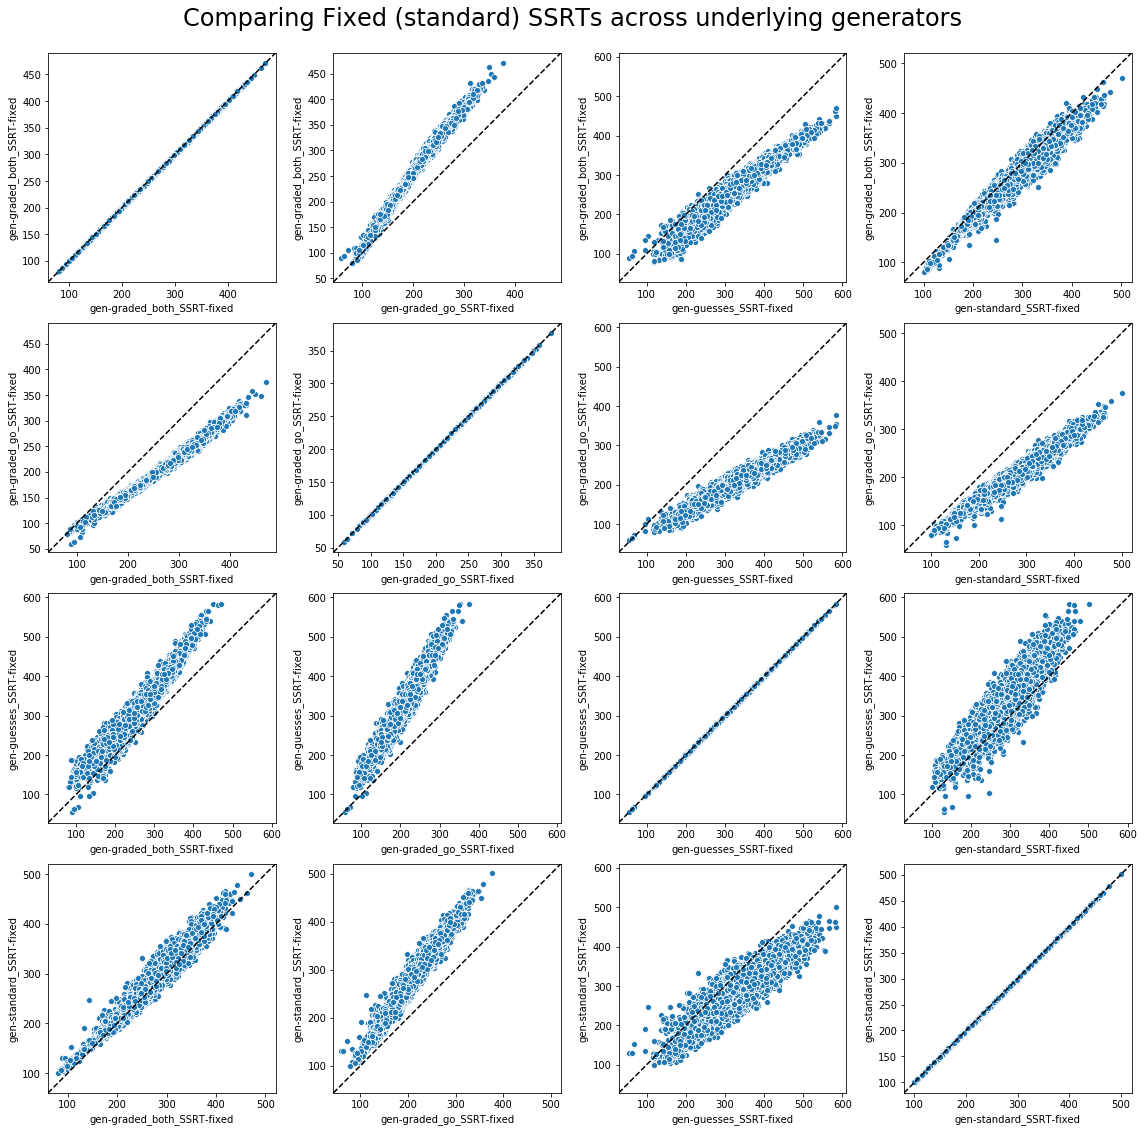

In [16]:
curr_df = monster_df.filter(regex='fixed')

fig, axes = plt.subplots(4, 4, figsize=(16,16))

for idx,coli in enumerate(curr_df.columns):
    for jdx, colj in enumerate(curr_df.columns):
        ax = sns.scatterplot(x=colj, y=coli, data=curr_df, ax=axes[idx, jdx])
        ax = make_plot_square(ax)
        _ = add_identity(ax, color='k', ls='--')
_ = fig.suptitle('Comparing Fixed (standard) SSRTs across underlying generators', fontsize=24)
fig.tight_layout()
fig.subplots_adjust(top=0.94)

In [17]:
curr_df.corr(method='spearman')

gen-graded_both_SSRT-fixed  \
gen-graded_both_SSRT-fixed                    1.000000   
gen-graded_go_SSRT-fixed                      0.995241   
gen-guesses_SSRT-fixed                        0.972849   
gen-standard_SSRT-fixed                       0.973496   

                            gen-graded_go_SSRT-fixed  gen-guesses_SSRT-fixed  \
gen-graded_both_SSRT-fixed                  0.995241                0.972849   
gen-graded_go_SSRT-fixed                    1.000000                0.969977   
gen-guesses_SSRT-fixed                      0.969977                1.000000   
gen-standard_SSRT-fixed                     0.975553                0.906937   

                            gen-standard_SSRT-fixed  
gen-graded_both_SSRT-fixed                 0.973496  
gen-graded_go_SSRT-fixed                   0.975553  
gen-guesses_SSRT-fixed                     0.906937  
gen-standard_SSRT-fixed                    1.000000

## (not rescaling the axes to get a closer look)

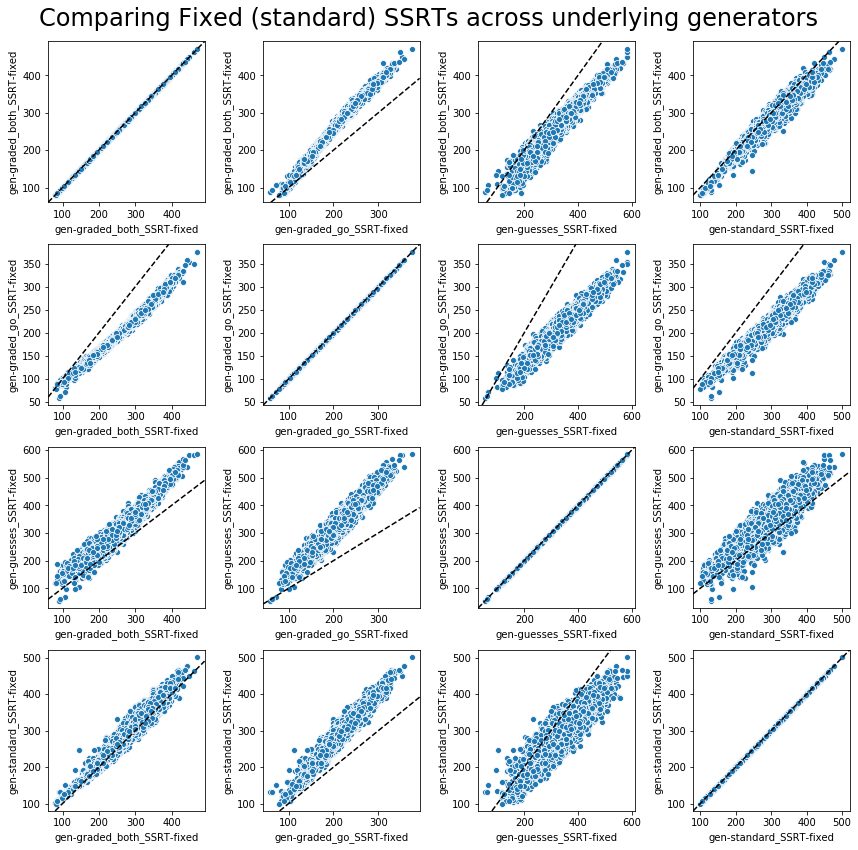

In [18]:
curr_df = monster_df.filter(regex='fixed')
fig, axes = plt.subplots(4, 4, figsize=(12,12))

for idx,coli in enumerate(curr_df.columns):
    for jdx, colj in enumerate(curr_df.columns):
        ax = sns.scatterplot(x=colj, y=coli, data=curr_df, ax=axes[idx, jdx])
#         ax = make_plot_square(ax)
        _ = add_identity(ax, color='k', ls='--')
_ = fig.suptitle('Comparing Fixed (standard) SSRTs across underlying generators', fontsize=24)
fig.tight_layout()
fig.subplots_adjust(top=0.94)

# Weighted SSRTs (from randomly assigned SSD distributions)

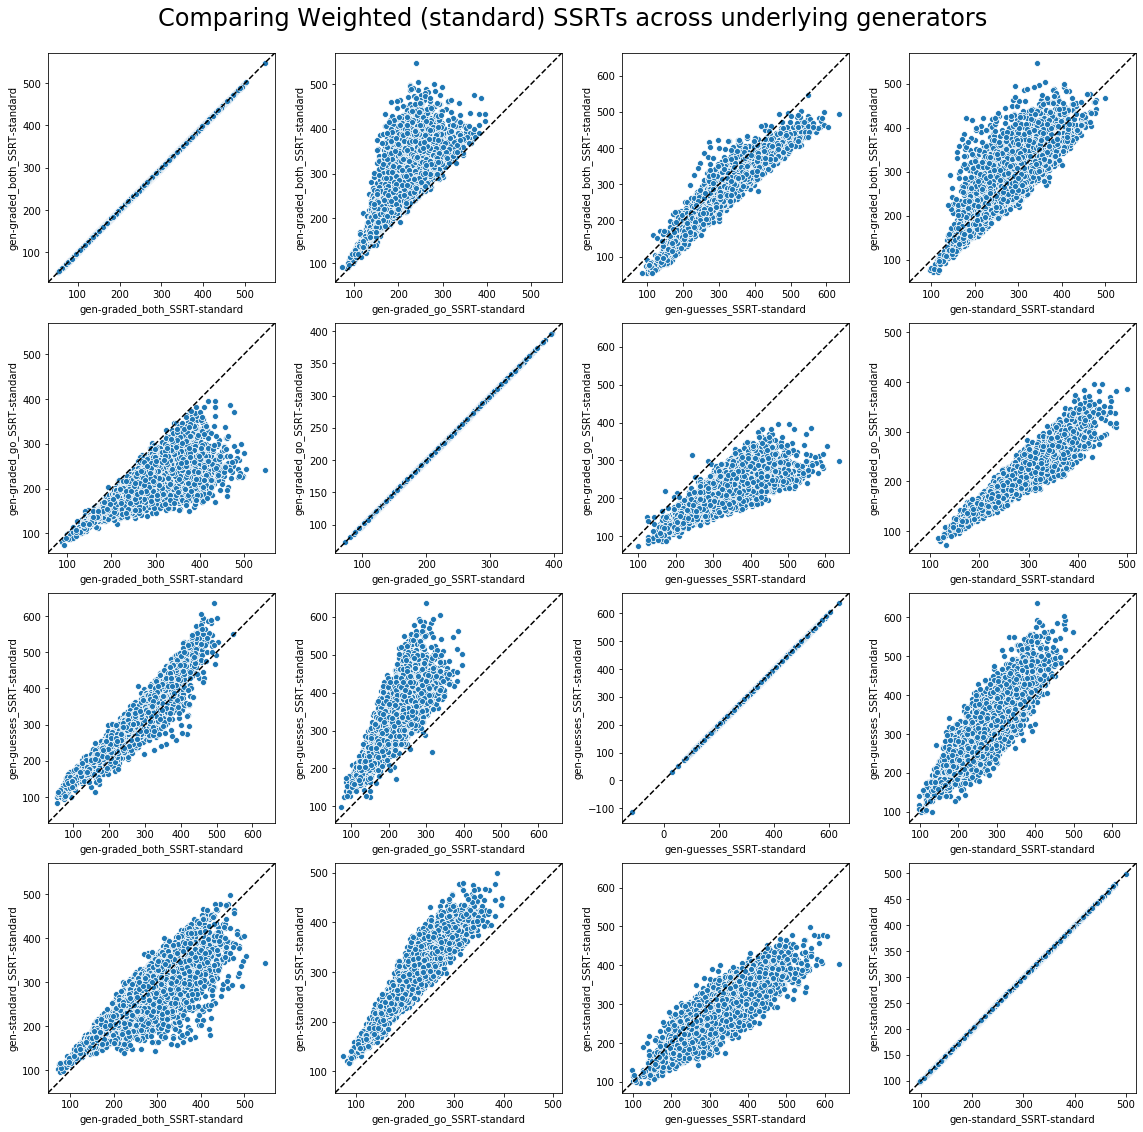

In [19]:
curr_df = monster_df.filter(regex='SSRT-standard')

fig, axes = plt.subplots(4, 4, figsize=(16,16))

for idx,coli in enumerate(curr_df.columns):
    for jdx, colj in enumerate(curr_df.columns):
        ax = sns.scatterplot(x=colj, y=coli, data=curr_df, ax=axes[idx, jdx])
        ax = make_plot_square(ax)
        _ = add_identity(ax, color='k', ls='--')
_ = fig.suptitle('Comparing Weighted (standard) SSRTs across underlying generators', fontsize=24)
fig.tight_layout()
fig.subplots_adjust(top=0.94)

In [20]:
curr_df.corr(method='spearman')

gen-graded_both_SSRT-standard  \
gen-graded_both_SSRT-standard                       1.000000   
gen-graded_go_SSRT-standard                         0.757557   
gen-guesses_SSRT-standard                           0.954635   
gen-standard_SSRT-standard                          0.847651   

                               gen-graded_go_SSRT-standard  \
gen-graded_both_SSRT-standard                     0.757557   
gen-graded_go_SSRT-standard                       1.000000   
gen-guesses_SSRT-standard                         0.800514   
gen-standard_SSRT-standard                        0.932054   

                               gen-guesses_SSRT-standard  \
gen-graded_both_SSRT-standard                   0.954635   
gen-graded_go_SSRT-standard                     0.800514   
gen-guesses_SSRT-standard                       1.000000   
gen-standard_SSRT-standard                      0.882841   

                               gen-standard_SSRT-standard  
gen-graded_both_SSRT-standard                    0.847651  
gen-graded_go_SSRT-standard                      0.932054  
gen-guesses_SSRT-standard                        0.882841  
gen-standard_SSRT-standard                       1.000000

## not rescaling axis to get a closer look

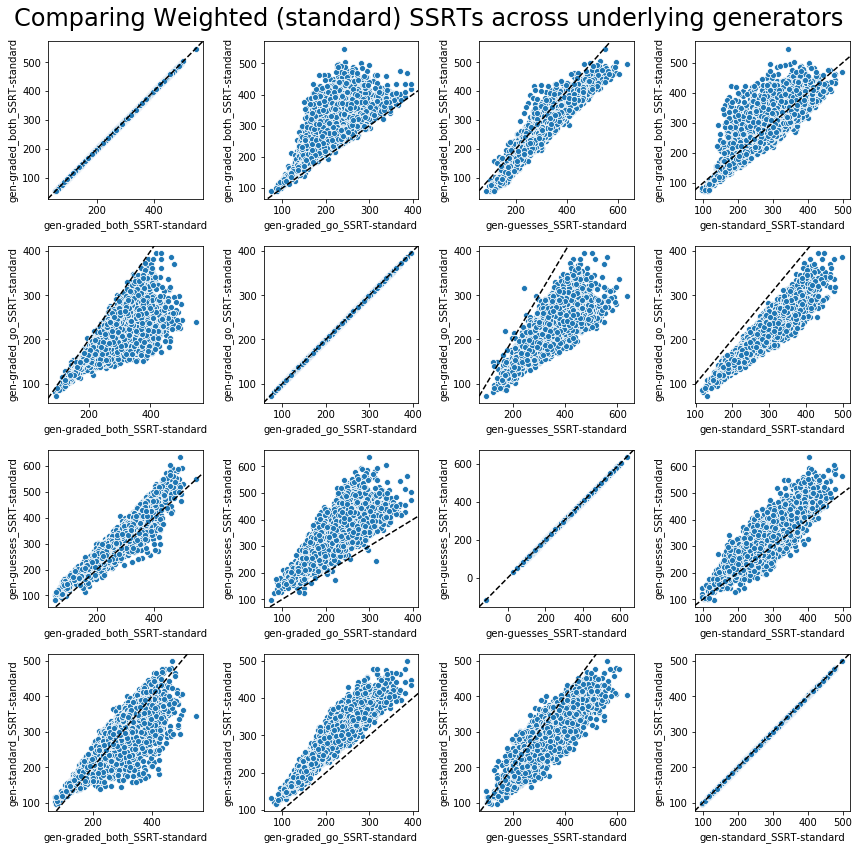

In [21]:
fig, axes = plt.subplots(4, 4, figsize=(12,12))

for idx,coli in enumerate(curr_df.columns):
    for jdx, colj in enumerate(curr_df.columns):
        ax = sns.scatterplot(x=colj, y=coli, data=curr_df, ax=axes[idx, jdx])
#         ax = make_plot_square(ax)
        _ = add_identity(ax, color='k', ls='--')
_ = fig.suptitle('Comparing Weighted (standard) SSRTs across underlying generators', fontsize=24)
fig.tight_layout()
fig.subplots_adjust(top=0.94)

# Tracking-based SSRTs

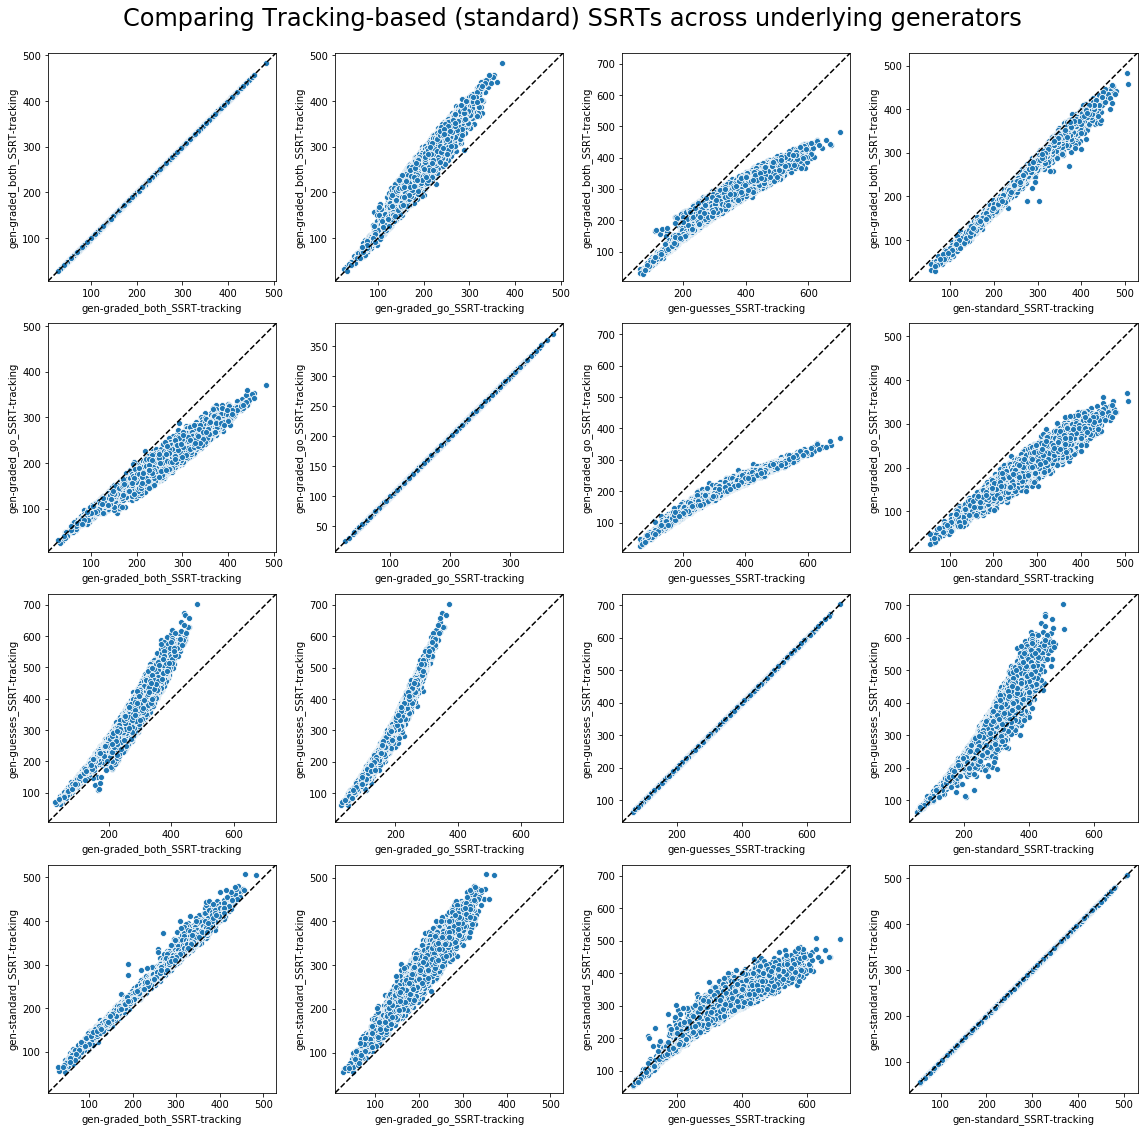

In [22]:
curr_df = monster_df.filter(regex='SSRT-tracking')

fig, axes = plt.subplots(4, 4, figsize=(16,16))

for idx,coli in enumerate(curr_df.columns):
    for jdx, colj in enumerate(curr_df.columns):
        ax = sns.scatterplot(x=colj, y=coli, data=curr_df, ax=axes[idx, jdx])
        ax = make_plot_square(ax)
        _ = add_identity(ax, color='k', ls='--')
_ = fig.suptitle('Comparing Tracking-based (standard) SSRTs across underlying generators', fontsize=24)
fig.tight_layout()
fig.subplots_adjust(top=0.94)

In [23]:
curr_df.corr(method='spearman')

gen-graded_both_SSRT-tracking  \
gen-graded_both_SSRT-tracking                       1.000000   
gen-graded_go_SSRT-tracking                         0.953062   
gen-guesses_SSRT-tracking                           0.957431   
gen-standard_SSRT-tracking                          0.994806   

                               gen-graded_go_SSRT-tracking  \
gen-graded_both_SSRT-tracking                     0.953062   
gen-graded_go_SSRT-tracking                       1.000000   
gen-guesses_SSRT-tracking                         0.988426   
gen-standard_SSRT-tracking                        0.948929   

                               gen-guesses_SSRT-tracking  \
gen-graded_both_SSRT-tracking                   0.957431   
gen-graded_go_SSRT-tracking                     0.988426   
gen-guesses_SSRT-tracking                       1.000000   
gen-standard_SSRT-tracking                      0.950957   

                               gen-standard_SSRT-tracking  
gen-graded_both_SSRT-tracking                    0.994806  
gen-graded_go_SSRT-tracking                      0.948929  
gen-guesses_SSRT-tracking                        0.950957  
gen-standard_SSRT-tracking                       1.000000

## not rescaling axes

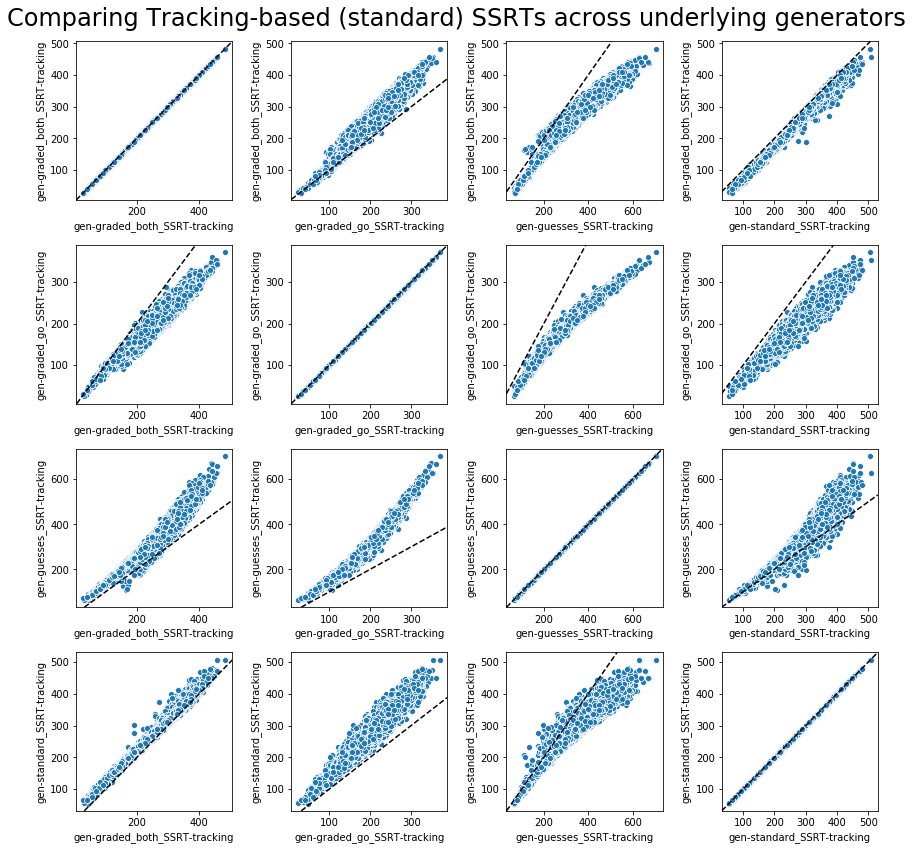

In [24]:
fig, axes = plt.subplots(4, 4, figsize=(12,12))

for idx,coli in enumerate(curr_df.columns):
    for jdx, colj in enumerate(curr_df.columns):
        ax = sns.scatterplot(x=colj, y=coli, data=curr_df, ax=axes[idx, jdx])
#         ax = make_plot_square(ax)
        _ = add_identity(ax, color='k', ls='--')
_ = fig.suptitle('Comparing Tracking-based (standard) SSRTs across underlying generators', fontsize=24)
fig.tight_layout()
fig.subplots_adjust(top=0.94)

In [25]:
main_cols = ['assigned_SSRT',
             'gen-graded_both_SSRT-standard',
             'gen-graded_go_SSRT-standard',
             'gen-guesses_SSRT-standard',
             'gen-standard_SSRT-standard',
             'gen-graded_both_SSRT-fixed',
             'gen-graded_go_SSRT-fixed',
             'gen-guesses_SSRT-fixed',
             'gen-standard_SSRT-fixed',
             'gen-graded_both_SSRT-tracking',
             'gen-graded_go_SSRT-tracking',
             'gen-guesses_SSRT-tracking',
             'gen-standard_SSRT-tracking']
monster_df[main_cols].describe()

assigned_SSRT  gen-graded_both_SSRT-standard  \
count    8207.000000                    8154.000000   
mean      299.826253                     272.458744   
std        84.233805                      69.718706   
min        60.351787                      53.516667   
25%       241.538011                     226.861404   
50%       300.272310                     274.220578   
75%       357.185976                     319.039881   
max       639.169021                     547.200000   

       gen-graded_go_SSRT-standard  gen-guesses_SSRT-standard  \
count                  7457.000000                8207.000000   
mean                    217.884667                 315.415535   
std                      46.904743                  77.688809   
min                      73.100000                -115.000000   
25%                     185.716667                 263.975000   
50%                     217.016667                 315.150000   
75%                     249.350000                 365.558704   
max                     396.477273                 636.000000   

       gen-standard_SSRT-standard  gen-graded_both_SSRT-fixed  \
count                 7990.000000                 8207.000000   
mean                   284.855281                  269.990618   
std                     63.414980                   60.434940   
min                     96.907407                   80.000000   
25%                    241.704167                  230.000000   
50%                    288.100000                  274.000000   
75%                    330.062500                  313.000000   
max                    499.650000                  471.000000   

       gen-graded_go_SSRT-fixed  gen-guesses_SSRT-fixed  \
count               8207.000000             8207.000000   
mean                 209.219569              328.550506   
std                   44.179897               74.609575   
min                   59.000000               55.000000   
25%                  179.000000              276.000000   
50%                  210.000000              330.000000   
75%                  240.000000              380.000000   
max                  376.000000              584.000000   

       gen-standard_SSRT-fixed  gen-graded_both_SSRT-tracking  \
count              8207.000000                    8207.000000   
mean                281.269526                     254.723290   
std                  62.445244                      74.360077   
min                 100.000000                      28.558000   
25%                 239.000000                     202.923000   
50%                 284.000000                     259.228000   
75%                 325.000000                     309.094000   
max                 501.000000                     483.066000   

       gen-graded_go_SSRT-tracking  gen-guesses_SSRT-tracking  \
count                  8207.000000                8207.000000   
mean                    200.977263                 329.086192   
std                      51.759073                  97.767814   
min                      24.980000                  63.678000   
25%                     166.788000                 259.701000   
50%                     203.990000                 329.242000   
75%                     237.496000                 396.363000   
max                     370.988000                 702.830000   

       gen-standard_SSRT-tracking  
count                 8207.000000  
mean                   276.698376  
std                     70.670105  
min                     54.368000  
25%                    228.792000  
50%                    280.514000  
75%                    326.774000  
max                    507.088000

In [26]:
ssrt_df.corr(method='spearman')

gen-graded_both_SSRT-standard  \
gen-graded_both_SSRT-standard                          1.000000   
gen-graded_go_SSRT-standard.1                          0.757557   
gen-guesses_SSRT-standard.2                            0.954635   
gen-standard_SSRT-standard.3                           0.847651   
gen-graded_both_SSRT-guesses                           0.825943   
gen-graded_go_SSRT-guesses.1                           0.249713   
gen-guesses_SSRT-guesses.2                             0.816506   
gen-standard_SSRT-guesses.3                            0.501764   
gen-graded_both_SSRT-graded_go                         0.810722   
gen-graded_go_SSRT-graded_go.1                         0.722622   
gen-guesses_SSRT-graded_go.2                           0.849671   
gen-standard_SSRT-graded_go.3                          0.765808   
gen-graded_both_SSRT-graded_both                       0.810722   
gen-graded_go_SSRT-graded_both.1                       0.722622   
gen-guesses_SSRT-graded_both.2                         0.849671   
gen-standard_SSRT-graded_both.3                        0.765808   
gen-graded_both_SSRT-fixed                             0.832326   
gen-graded_go_SSRT-fixed.1                             0.830571   
gen-guesses_SSRT-fixed.2                               0.802439   
gen-standard_SSRT-fixed.3                              0.823044   
gen-graded_both_SSRT-tracking                          0.797071   
gen-graded_go_SSRT-tracking.1                          0.831524   
gen-guesses_SSRT-tracking.2                            0.827595   
gen-standard_SSRT-tracking.3                           0.793582   

                                  gen-graded_go_SSRT-standard.1  \
gen-graded_both_SSRT-standard                          0.757557   
gen-graded_go_SSRT-standard.1                          1.000000   
gen-guesses_SSRT-standard.2                            0.800514   
gen-standard_SSRT-standard.3                           0.932054   
gen-graded_both_SSRT-guesses                           0.846047   
gen-graded_go_SSRT-guesses.1                           0.773116   
gen-guesses_SSRT-guesses.2                             0.937278   
gen-standard_SSRT-guesses.3                            0.804657   
gen-graded_both_SSRT-graded_go                         0.400196   
gen-graded_go_SSRT-graded_go.1                         0.817107   
gen-guesses_SSRT-graded_go.2                           0.457629   
gen-standard_SSRT-graded_go.3                          0.593833   
gen-graded_both_SSRT-graded_both                       0.400196   
gen-graded_go_SSRT-graded_both.1                       0.817107   
gen-guesses_SSRT-graded_both.2                         0.457629   
gen-standard_SSRT-graded_both.3                        0.593833   
gen-graded_both_SSRT-fixed                             0.955428   
gen-graded_go_SSRT-fixed.1                             0.960141   
gen-guesses_SSRT-fixed.2                               0.893304   
gen-standard_SSRT-fixed.3                              0.967091   
gen-graded_both_SSRT-tracking                          0.942651   
gen-graded_go_SSRT-tracking.1                          0.963762   
gen-guesses_SSRT-tracking.2                            0.961715   
gen-standard_SSRT-tracking.3                           0.940640   

                                  gen-guesses_SSRT-standard.2  \
gen-graded_both_SSRT-standard                        0.954635   
gen-graded_go_SSRT-standard.1                        0.800514   
gen-guesses_SSRT-standard.2                          1.000000   
gen-standard_SSRT-standard.3                         0.882841   
gen-graded_both_SSRT-guesses                         0.774916   
gen-graded_go_SSRT-guesses.1                         0.281910   
gen-guesses_SSRT-guesses.2                           0.856410   
gen-standard_SSRT-guesses.3                          0.521678   
gen-graded_both_SSRT-graded_go                       0.699883   
gen-graded_go_SSRT-graded_go.1  

## How many subs survived (i.e. didn't have non-null SSRTs)

This can occur during the weighted method if one of their SSD-specific SSRTs is null. Not sure if you want me to fix.

In [27]:
monster_df.columns

options = ['standard', 'guesses', 'graded_go', 'graded_both']

for gen_str in options:
    for ssrt_str in options:
        col = 'gen-%s_SSRT-%s' % (gen_str, ssrt_str)
        print(col, len(monster_df.loc[monster_df[col].notnull()]))

gen-standard_SSRT-standard 7990
gen-standard_SSRT-guesses 7990
gen-standard_SSRT-graded_go 7990
gen-standard_SSRT-graded_both 7990
gen-guesses_SSRT-standard 8207
gen-guesses_SSRT-guesses 8207
gen-guesses_SSRT-graded_go 8207
gen-guesses_SSRT-graded_both 8207
gen-graded_go_SSRT-standard 7457
gen-graded_go_SSRT-guesses 7457
gen-graded_go_SSRT-graded_go 7457
gen-graded_go_SSRT-graded_both 7457
gen-graded_both_SSRT-standard 8154
gen-graded_both_SSRT-guesses 8154
gen-graded_both_SSRT-graded_go 8154
gen-graded_both_SSRT-graded_both 8154


In [28]:
ssrt_df.filter(regex='SSRT-tracking').describe()

gen-graded_both_SSRT-tracking  gen-graded_go_SSRT-tracking.1  \
count                    8207.000000                    8207.000000   
mean                      254.723290                     200.977263   
std                        74.360077                      51.759073   
min                        28.558000                      24.980000   
25%                       202.923000                     166.788000   
50%                       259.228000                     203.990000   
75%                       309.094000                     237.496000   
max                       483.066000                     370.988000   

       gen-guesses_SSRT-tracking.2  gen-standard_SSRT-tracking.3  
count                  8207.000000                   8207.000000  
mean                    329.086192                    276.698376  
std                      97.767814                     70.670105  
min                      63.678000                     54.368000  
25%                     259.701000                    228.792000  
50%                     329.242000                    280.514000  
75%                     396.363000                    326.774000  
max                     702.830000                    507.088000